In [20]:
# Code adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/ac5dcd03a40a08a8af7e1a67ade37f28cf88db43/ML/Pytorch/GANs/2.%20DCGAN/train.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader

import os, math
import sys
import shutil
import random
import numpy as np
import skfmm

import GAN as GAN
from GAN import Generator
from GAN import Critic

import wandb

import data_manager as dm

import matplotlib.pyplot as plt

## Initialize Weights and Biases

#### Configure the run

In [2]:
RECORD_METRICS = True

# Checkpoint saving directory
# loc = os.getcwd()
loc = '/data'

# Inputs
# DATASET = 'random_40_density'
# SUBSET = 'train'
# BATCH_SIZE = 50
DATASET = 'single_20_density_large_2'
SUBSET = 'train'
BATCH_SIZE = 64


# Structure
NUM_LAYERS_CRIT = 5
KERNEL_CRIT = [4,4,4,4,4]
STRIDE_CRIT = [2,2,2,2,1]
PAD_CRIT = [1,1,1,1,0]
FEATURES_CRIT = [3,64,128,256,512,1]

NUM_LAYERS_GEN = 10
# KERNEL_GEN = [4,4,4,4,4,4,4,4,4,4]
# STRIDE_GEN = [2,2,2,2,1,1,2,2,2,2]
# PAD_GEN = [1,1,1,1,0,0,1,1,1,1]
# FEATURES_GEN = [3,64,128,256,512,1024,512,256,128,64,1]
KERNEL_GEN = [4,4,4,4,4,1,4,4,4,4,4]
STRIDE_GEN = [2,2,2,2,1,1,1,2,2,2,2]
PAD_GEN = [1,1,1,1,0,0,0,1,1,1,1]
FEATURES_GEN = [3,64,128,256,512,1024,1024,512,256,128,64,1]


# Hyperparameters
LR_CRIT = 1e-5
LR_GEN = 1e-4
CRIT_ITERATIONS = 5
LAMBDA = 10


# Internal Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAP_SHAPE = (64,64)
NOISE_SHAPE = (BATCH_SIZE, 1, MAP_SHAPE[0], MAP_SHAPE[1])

NUM_EPOCHS = 20
START_EPOCH = 0

Initialize WandB

In [3]:
GROUP=''

CONFIG = dict(
    dataset = DATASET,
    subset = SUBSET,

    layers_crit = NUM_LAYERS_CRIT,
    kernels_crit = KERNEL_CRIT,
    stride_crit = STRIDE_CRIT,
    padding_crit = PAD_CRIT,
    features_crit = FEATURES_CRIT,

    layers_gen = NUM_LAYERS_GEN,
    kernels_gen = KERNEL_GEN,
    stride_gen = STRIDE_GEN,
    padding_gen = PAD_GEN,
    features_gen = FEATURES_GEN,

    batch_size = BATCH_SIZE,
    learning_rate_crit = LR_CRIT,
    learning_rate_gen = LR_GEN,
    crit_iterations = CRIT_ITERATIONS,
    gp_coefficient = LAMBDA
)

if RECORD_METRICS:
    run = wandb.init(project='wgan-gp', entity='aicv-lab', config=CONFIG, group=GROUP)

wandb: Currently logged in as: sploeger (aicv-lab). Use `wandb login --relogin` to force relogin


## Define The GAN's Structure

In [4]:
# Save the GAN's definitions and hyperparams
if RECORD_METRICS:
    dm.save_gan(run.name, CONFIG)

## Define Essential Functions

In [5]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
def gradient_penalty(coeff, critic, real, fake, device="cpu"):
    # sample x_hat from P(x_hat)
    rand = torch.randn((real.shape[0], 1, 1, 1), device=device) # generate a random number from 0 to 1 for each matrix in the batch
    x_hat = rand*real + (1-rand)*fake

    critic_output = critic(x_hat)
    grad_ones = torch.ones_like(critic_output, device=device)

    gp = torch.autograd.grad(                                   # find magnitude of critic's resulting gradient
        inputs = x_hat,
        outputs = critic_output,
        grad_outputs = grad_ones,
        create_graph = True,
        retain_graph = True
    )[0]

    gp = torch.norm(gp, p=2, dim=(1,2,3))    # vector norm of each gradient
    gp = (gp - 1)**2
    gp = coeff * torch.mean(gp)

    return gp

In [7]:
# Need to override __init__, __len__, __getitem__  as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, subset, device='cpu'):
        self.device = device
        self.paths = dm.load_input(dataset, subset) # Load all of the paths in the specified set

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = self.paths[idx]
        x = x.to(self.device)
        return x

## Initialize Model & Data

In [8]:
train_dataset = PathsDataset(DATASET, SUBSET, device=device)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [15]:
test_load = dm.load_paths("./datasets/single_30_density/train/map_0/paths")
x = 0

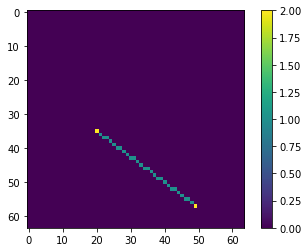

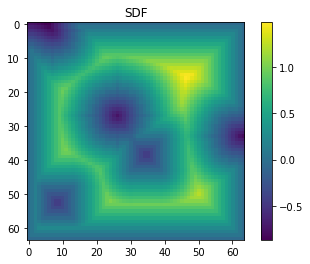

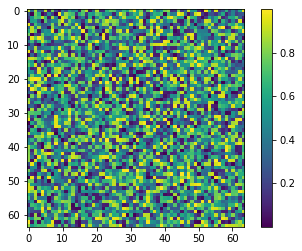

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


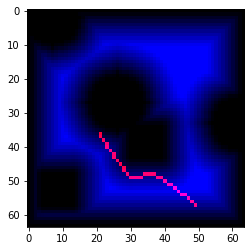

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


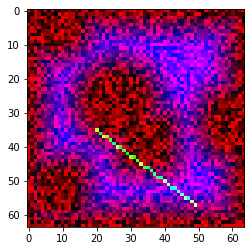

In [33]:
# plots figures 1-4 in report
for batch_idx, real in enumerate(dataloader):
    points = test_load[x]
    fixed_noise = torch.rand(NOISE_SHAPE, device=device)
    fixed_input = torch.concat((fixed_noise, real[:,1:,:,:]), axis=1)
    inputs = real[:8,:,:,:]
    outputs = fixed_input[:8,1:,:,:]
    plt.imshow(outputs[0][0].cpu())
    plt.colorbar()
    plt.show()

    plt.imshow(outputs[0][1].cpu())  # SDF
    plt.title('SDF')
    # plt.scatter(points[:,1], points[:,0])
    plt.colorbar()
    plt.show()

    # outputs[0][1][outputs[0][1]>=0] = 0
    # outputs[0][1][outputs[0][1]<0] = 1
    # plt.imshow(outputs[0][1].cpu())
    # new_output = outputs[0][1].cpu()
    # plt.colorbar()
    # plt.show()

    plt.imshow(fixed_noise[0][0].cpu())
    plt.colorbar()
    plt.show()

    # plt.imshow(np.logical_or(inputs[0][0].cpu(),new_output))
    # # plt.imshow(inputs[0][0].cpu())
    # # plt.colorbar()
    # plt.show()

    plt.imshow(np.stack((real[0][0].cpu(),np.zeros_like(outputs[0][1].cpu()) ,outputs[0][1].cpu()), axis=-1))
    plt.show()

    newTensor = outputs[0][0:2]
    newTensor = torch.concat((fixed_noise[0][0:1], newTensor), axis=0)
    plt.imshow(newTensor.cpu().permute(1,2,0))

    x = x + 1

    break
    

In [11]:
curr_epoch = START_EPOCH

gen = Generator(FEATURES_GEN, KERNEL_GEN, STRIDE_GEN, PAD_GEN, device=device)
critic = Critic(FEATURES_CRIT, KERNEL_CRIT, STRIDE_CRIT, PAD_CRIT, device=device)

opt_gen = optim.Adam(gen.parameters(), lr=LR_GEN, betas = (0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LR_CRIT, betas = (0.0, 0.9))

initialize_weights(gen)
initialize_weights(critic)

In [12]:
# fixed_noise = torch.rand(NOISE_SHAPE, device=device)

gen.train()
critic.train()

Critic(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=Fa

## Train the Model

In [13]:
for epoch in range(NUM_EPOCHS):
    curr_epoch += 1
    for batch_idx, real in enumerate(dataloader):
        fixed_noise = torch.rand(NOISE_SHAPE, device=device)
        fixed_input = torch.concat((fixed_noise, real[:,1:,:,:]), axis=1)   # for the batch it's gets everything except the first layer (the training/true path)
                                                                            # real contains the endpoints and map

        for _ in range(CRIT_ITERATIONS):
            noise = torch.randn_like(real[:,-1:,:,:], device=device).abs()
            noise = torch.concat((noise, real[:,1:,:,:]), axis=1)

            fake = gen(noise)
            fake = torch.concat((fake, real[:,1:,:,:]), axis=1)

            critic_real = critic(real)
            critic_fake = critic(fake)
            gp = gradient_penalty(LAMBDA, critic, real, fake, device=device) # compute the gradient penalty
            loss_critic = (
                torch.mean(critic_fake) - torch.mean(critic_real) + gp
            )

            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        ### Training generator: min E(critic(gen_fake))
        output = critic(fake)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{curr_epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} " +
                  f"Loss D: {loss_critic:.4f}, Lambda GP: {gp:.4f}, loss G: {loss_gen:.4f}"
            )

            if RECORD_METRICS:
                dm.save_checkpoint(run.name, run.step, gen, critic, loc)

            # make noise
            # concat to make the input as usual (noise, endpoints, map)
            # feed this input to gan

            if BATCH_SIZE > 8:
                outputs = gen(fixed_input[:8,:,:,:]) # fixed input is (noise, endpoints, SDF map)
                inputs = real[:8,:,:,:] # this is the "real" that we view in wandb
                outputs = torch.concat((outputs, fixed_input[:8,1:,:,:]), axis=1)   # this is the "fake" that we see in wandb
                                                                                    # fixed_input[:8,1:,:,:]) means (for the batch) ignore channel 0 (noise), take endpoints and SDF map
                                                                                    # concat generated path with endpoints and SDF map
            else:
                outputs = gen(fixed_input)
                inputs = real
                outputs = torch.concat((outputs, fixed_input[:,1:,:,:]), axis=1)

            if RECORD_METRICS:
                wandb.log({
                    'epoch': curr_epoch,
                    'generator loss': loss_gen,
                    'critic loss': loss_critic,
                    'gradient penalty': gp,
                    'fake': wandb.Image(outputs),
                    'real': wandb.Image(inputs)
                })

Epoch [1/20] Batch 0/3906 Loss D: 355.2520, Lambda GP: 354.7577, loss G: 2.2609
Epoch [1/20] Batch 100/3906 Loss D: -0.8413, Lambda GP: 0.0271, loss G: -14.3856
Epoch [1/20] Batch 200/3906 Loss D: -1.6065, Lambda GP: 0.0580, loss G: -13.8161
Epoch [1/20] Batch 300/3906 Loss D: -1.8431, Lambda GP: 0.0872, loss G: -14.5074
Epoch [1/20] Batch 400/3906 Loss D: -2.0767, Lambda GP: 0.1333, loss G: -14.1577
Epoch [1/20] Batch 500/3906 Loss D: -2.1514, Lambda GP: 0.2533, loss G: -14.2944
Epoch [1/20] Batch 600/3906 Loss D: -0.9371, Lambda GP: 0.0894, loss G: -16.6523
Epoch [1/20] Batch 700/3906 Loss D: -1.3752, Lambda GP: 0.0645, loss G: -17.1359
Epoch [1/20] Batch 800/3906 Loss D: -0.7390, Lambda GP: 0.0632, loss G: -17.5871
Epoch [1/20] Batch 900/3906 Loss D: -1.0075, Lambda GP: 0.0515, loss G: -17.4531
Epoch [1/20] Batch 1000/3906 Loss D: -0.8282, Lambda GP: 0.0464, loss G: -17.2766
Epoch [1/20] Batch 1100/3906 Loss D: -1.5124, Lambda GP: 0.1166, loss G: -16.6068
Epoch [1/20] Batch 1200/390

In [14]:
if RECORD_METRICS:
    wandb.finish()

critic loss,██▇▇▇▇▇▇▇▄▇▇█▇█▄▇▅▇█▇▄▇▇▇▇▇▇▆▆▅▁▅▆▇▇▆▅▇▇
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
generator loss,▁▄▅▅▄▄▄▄▃▆▃▃▃▃▃▅▃▄▂▂▃▆▂▂▂▂▂▃▃▃▄█▄▄▃▃▃▅▃▃
gradient penalty,▁▁▂▂▂▂▁▂▁▆▂▁▂▂▂▄▂▄▂▂▂█▂▁▂▂▃▃▄▃▅█▂▂▂▂▃▇▃▂
critic loss,-4.51556
epoch,20
generator loss,-9.0868
gradient penalty,1.13446
